In [116]:
#Final CODE PARALLEL
import numpy as np
from numpy.linalg import eigh
import pyspark
from pyspark import SparkContext
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix


def create_block_matrix_from_numpy(
    np_array: np.ndarray,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Create a BlockMatrix from a NumPy array.
    
    Args:
        np_array (np.ndarray): NumPy array to be converted
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: SparkContext for parallelization
        
    Returns:
        BlockMatrix: Distributed block matrix representation of input array
    """
    num_rows: int = 0
    num_cols: int = 0
    blocks: list = []
    blocks_rdd: pyspark.RDD = None
    block_dense_matrix: Matrices.dense = None
    
    num_rows, num_cols = np_array.shape

    for j in range(0, num_cols, col_block_count):
        for i in range(0, num_rows, row_block_count):
            block = np_array[i:i + row_block_count, j:j + col_block_count]
            block_dense_matrix = Matrices.dense(block.shape[0], block.shape[1], block.T.flatten())
            blocks.append(((i // row_block_count, j // col_block_count), block_dense_matrix))

    blocks_rdd = sc.parallelize(blocks)
    
    return BlockMatrix(blocks_rdd, row_block_count, col_block_count)
    
def svd(
    gram_mat: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Perform Singular Value Decomposition (SVD) on a Gramian matrix.
    
    Args:
        gram_mat (BlockMatrix): The input Gramian matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    
    Returns:
        tuple[BlockMatrix, BlockMatrix, BlockMatrix]: The U, Sigma-inverse, and V^T matrices as BlockMatrices.
    """
    matrix_size: int = 0
    tol: float = 0.0
    arr: np.ndarray = None
    eigval_V: np.ndarray = None
    eigvecs: np.ndarray = None
    idx: np.ndarray = None
    eigvals_inv: np.ndarray = None
    block_s_inv: BlockMatrix = None
    block_v: BlockMatrix = None
    
    tol = 1e-15

    # Compute and sort eigenvalues and eigenvectors with a numpy Array.
    arr = gram_mat.toLocalMatrix().toArray()
    eigval_V, eigvecs = np.linalg.eigh(arr)
    idx = eigval_V.argsort()[::-1]
    eigval_V = eigval_V[idx]
    eigvecs = eigvecs[:, idx]

    # Invert eigenvalues (set small ones to zero) and form a diagonal matrix.
    eigvals_inv = np.array([1/val if val > tol else 0 for val in eigval_V])
    eigvals_inv = np.diag(eigvals_inv)
    
    # Convert results to block matrices for Spark and transpose the eigenvectors.
    block_s_inv = create_block_matrix_from_numpy(eigvals_inv, int(math.ceil(eigvals_inv.shape[0]/n_workers)), int(math.ceil(eigvals_inv.shape[1]/n_workers)), sc)

    block_v = create_block_matrix_from_numpy(eigvecs, int(math.ceil(eigvecs.shape[0]/n_workers)), int(math.ceil(eigvecs.shape[1]/n_workers)), sc)
    
    return block_v.multiply(block_s_inv).multiply(block_v.transpose())

def betacalc(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Calculate the beta values for the input matrices X and Y.
    
    Args:
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    
    Returns:
        np.ndarray: The computed beta values.
    """
    XtX: BlockMatrix = None
    XtX_inv: BlockMatrix = None
    beta: BlockMatrix = None

    # Compute gram-matrix
    XtX = X.transpose().multiply(X)

    # Invert XtX using SVD.
    XtX_inv = svd(XtX, row_block_count, col_block_count, sc)

    # Compute and return betas
    beta = XtX_inv.multiply(X.transpose()).multiply(Y)
    return beta

def lm_values(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
):
    """
    Compute comprehensive linear model statistics.
    Returns a flat dictionary of statistics.
    
    Args:  
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    Returns:
        Dict: OLS statistics
    """
    
    # Calculate beta and convert to local
    beta = betacalc(X, Y, row_block_count, col_block_count, sc)
    fitted_values = X.multiply(beta)
    residuals = Y.subtract(fitted_values)
    
    fitted_local = fitted_values.toLocalMatrix().toArray()
    residuals_local = residuals.toLocalMatrix().toArray()
     beta_local = beta.toLocalMatrix().toArray()

    # Residual quartiles
    min_residuals = np.min(residuals_local)
    q1_residuals = np.percentile(residuals_local, 25)
    median_residuals = np.median(residuals_local)
    q3_residuals = np.percentile(residuals_local, 75)
    max_residuals = np.max(residuals_local)
    
    # Get local matrices for calculations
    X_local = X.toLocalMatrix().toArray()
    Y_local = Y.toLocalMatrix().toArray()
    
    # Basic dimensions
    n = X.numRows()
    p = X.numCols()
    degrees_of_freedom = n - p
    
    # Residual statistics
    rss = np.sum(residuals_local ** 2)  # Residual sum of squares
    mse = rss / degrees_of_freedom
    rmse = np.sqrt(mse)
    
    # Calculate XtX and its inverse for standard errors
    XtX = X.transpose().multiply(X)
    XtX_local = XtX.toLocalMatrix().toArray()
    XtX_inv = np.linalg.inv(XtX_local)
    
    # Standard errors and t-values
    beta_std_errors = np.sqrt(np.diag(XtX_inv) * mse)
    t_values = beta_local.flatten() / beta_std_errors
    
    # R-squared statistics
    y_mean = np.mean(Y_local)
    tss = np.sum((Y_local - y_mean) ** 2)  # Total sum of squares
    r_squared = 1 - (rss / tss)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / degrees_of_freedom)
    
    # F-statistic
    model_ss = tss - rss
    f_statistic = (model_ss / (p - 1)) / mse
    
    # Information criteria
    aic = n * np.log(rss / n) + 2 * p
    bic = n * np.log(rss / n) + p * np.log(n)
    
    # save all statistics in Dict
    statistics = {
        'betas': beta_local.flatten(),
        'beta_std_errors': beta_std_errors,
        't_values': t_values,
        'residuals': residuals_local.flatten(),
        'fitted_values': fitted_local.flatten(),
        'min_residuals': min_residuals,
        'q1_residuals': q1_residuals,
        'median_residuals': median_residuals,
        'q3_residuals': q3_residuals,
        'max_residuals': max_residuals,
        'n_observations': n,
        'n_parameters': p,
        'degrees_of_freedom': degrees_of_freedom,
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_statistic': f_statistic,
        'aic': aic,
        'bic': bic,
        'residual_sum_squares': rss,
        'total_sum_squares': tss,
        'sigma': np.sqrt(mse)
    }
    
    return statistics

In [125]:
import time
from pyspark.sql import SparkSession
import math


def create_random_block_matrix_and_vector(n_rows: int, n_cols: int, row_block_count: int, col_block_count: int, sc):
    """
    Create random BlockMatrices for testing linear regression.
    
    Args:
        n_rows (int): Number of rows in the feature matrix
        n_cols (int): Number of columns in the feature matrix
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: SparkContext for parallelization
        
    Returns:
        tuple[BlockMatrix, BlockMatrix]: Random feature matrix X and target vector Y as BlockMatrices,
        where X is of shape (n_rows, n_cols) and Y is of shape (n_rows, 1)
    """
    np.random.seed(42)
    X = np.random.rand(n_rows, n_cols)
    Y = np.random.rand(n_rows, 1)

    X_block_matrix = create_block_matrix_from_numpy(X, row_block_count, col_block_count, sc)
    Y_block_matrix = create_block_matrix_from_numpy(Y, row_block_count, 1, sc)
    
    return X_block_matrix, Y_block_matrix

#Hyperparameter
#n_features_list = [10, 50, 100, 500, 1000]
n_features_list = [5, 10, 20, 30, 40]
n_rows = max(n_features_list) * 30
elapsed_times = []
avg_elapsed_times = []
times_per_feature = []
n_times = 10
n_workers = 4


# Create Sparksession
spark = SparkSession.builder \
    .appName("Cluster-Based SVD Regression") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.default.parallelism", n_workers) \
    .config("spark.sql.shuffle.partitions", n_workers) \
    .getOrCreate()

sc = spark.sparkContext

# Run OLS for n-features and measure performance
for n_features in n_features_list:
    row_block_count = math.ceil(n_rows/n_workers)
    col_block_count = math.ceil(n_features/n_workers)
    matX, matY = create_random_block_matrix_and_vector(n_rows, n_features,row_block_count,col_block_count,sc)  
    elapsed_time = 0

    
    for a in range(n_times):
        start_time = time.time()
        stat = lm_values(matX, matY, row_block_count, col_block_count, sc)
        elapsed_time = elapsed_time + (time.time() - start_time)
        print("Betas: ",stat['betas'])
        print("beta_std_errors: ",stat['beta_std_errors'])
        print("t_values: ",stat['t_values'])
        
    avg_elapsed_time = elapsed_time / n_times 
    time_per_feature = avg_elapsed_time / n_features 
    elapsed_times.append(elapsed_time)
    avg_elapsed_times.append(avg_elapsed_time)
    times_per_feature.append(time_per_feature)
    print(f"Features: {n_features}, Gesamtzeit: {elapsed_time:.5f} Sekunden")
    print(f"Features: {n_features}, durchschnittliche Zeit: {avg_elapsed_time:.5f} Sekunden")
    print(f"Features: {n_features}, durchschnittliche Zeit pro feature: {time_per_feature:.5f} Sekunden")
    


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]


Betas:  [0.15946502 0.18076923 0.22055094 0.18554737 0.18971802]
beta_std_errors:  [0.02770009 0.0277263  0.02799291 0.02831136 0.02854006]
t_values:  [5.75684073 6.51977388 7.87881539 6.55381336 6.64742871]
Features: 5, Gesamtzeit: 103.99097 Sekunden
Features: 5, durchschnittliche Zeit: 10.39910 Sekunden
Features: 5, durchschnittliche Zeit pro feature: 2.07982 Sekunden


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]


Betas:  [0.1185726  0.10960358 0.11822258 0.05461051 0.07793368 0.09759982
 0.074419   0.14592134 0.08439453 0.08883046]
beta_std_errors:  [0.02897766 0.02866761 0.02836084 0.02935021 0.02859273 0.02881214
 0.02904236 0.02861707 0.02939696 0.02925685]
t_values:  [4.09186271 3.82325418 4.16851511 1.86065106 2.72564655 3.38745478
 2.56242946 5.09910067 2.8708591  3.03622785]
Features: 10, Gesamtzeit: 91.42569 Sekunden
Features: 10, durchschnittliche Zeit: 9.14257 Sekunden
Features: 10, durchschnittliche Zeit pro feature: 0.91426 Sekunden


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]


Betas:  [ 0.0283228   0.03347126  0.04102853  0.00033086  0.04094     0.04572401
  0.05915546  0.1134863   0.01189002  0.10303733  0.0381637   0.05781436
  0.02331125  0.07467574  0.10858555  0.09966531 -0.01285215  0.04641823
  0.03117183  0.04110408]
beta_std_errors:  [0.02884237 0.02873575 0.02883733 0.02949221 0.02886377 0.02837784
 0.0286025  0.02817846 0.0300101  0.02909865 0.02850943 0.02797662
 0.02851659 0.02941303 0.02925349 0.02883049 0.02920763 0.02850659
 0.02868078 0.02880242]
t_values:  [ 0.98198587  1.16479516  1.42275779  0.01121872  1.41838726  1.6112577
  2.06819188  4.0274127   0.39620047  3.5409653   1.33863438  2.06652422
  0.81746267  2.53886572  3.71188351  3.45694067 -0.4400271   1.62833357
  1.08685432  1.42710501]
Features: 20, Gesamtzeit: 88.78143 Sekunden
Features: 20, durchschnittliche Zeit: 8.87814 Sekunden
Features: 20, durchschnittliche Zeit pro feature: 0.44391 Sekunden


Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.04299198  0.03096253 -0.00046098  0.01357594  0.00851669  0.05635201
  0.02868846  0.02993525  0.02030634  0.06552096 -0.00663422  0.05189705
  0.0161475   0.05602203  0.06274265  0.00734532  0.03943711  0.07461723
  0.04106663  0.04862897  0.0456511   0.03499723  0.01768815 -0.00491548
  0.0079015   0.0215588   0.06211121  0.06265519  0.04280562 -0.00137153]
beta_std_errors:  [0.0292615  0.02952862 0.02966241 0.02967078 0.02952082 0.02922144
 0.02999159 0.02869158 0.03034811 0.02911879 0.02996414 0.02881058
 0.02981591 0.02934942 0.02923176 0.02938957 0.02972748 0.02905953
 0.02964948 0.02940769 0.02950913 0.02905667 0.02966153 0.03019262
 0.03071779 0.02915121 0.02960488 0.02992165 0.02976742 0.0297249 ]
t_values:  [ 1.46923355  1.04856009 -0.01554076  0.45755241  0.28849768  1.92844722
  0.95655009  1.04334612  0.66911372  2.25012695 -0.22140524  1.80131894
  0.54157342  1.90879519  2.14638656  0.24992942  1.32662135  2.56773738
  1.38507098  1.65361403  1.54701586  1.20

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

Betas:  [ 0.03351468  0.03517524 -0.0107353   0.01843021  0.01665111  0.01775513
  0.05243761  0.00708536 -0.00274067  0.00050622  0.03834258  0.00223547
  0.05263204  0.00033235 -0.00262388  0.0588243  -0.02760962  0.04902697
 -0.01154764  0.05961257  0.01263292  0.07977915  0.0308185  -0.0066956
  0.04860193  0.05163098 -0.03027814 -0.01235795  0.01507727  0.08782645
  0.03435507  0.01301019  0.05254075  0.03007586  0.00200437  0.06351197
  0.03574223  0.01457898  0.04001585  0.01538939]
beta_std_errors:  [0.02962907 0.02895058 0.02960882 0.02917168 0.02890334 0.02915422
 0.02916561 0.02867051 0.03008399 0.02957051 0.02931318 0.02905454
 0.0295459  0.0289828  0.02998021 0.02898838 0.03028674 0.02906618
 0.0301106  0.02960286 0.02944367 0.0294009  0.02970741 0.02933708
 0.02976844 0.02914776 0.0295408  0.02926649 0.02968517 0.02918319
 0.02929653 0.02924559 0.02980834 0.02962492 0.02965566 0.02999141
 0.02933854 0.02982335 0.02974867 0.02934329]
t_values:  [ 1.13114184  1.21501001 -0.

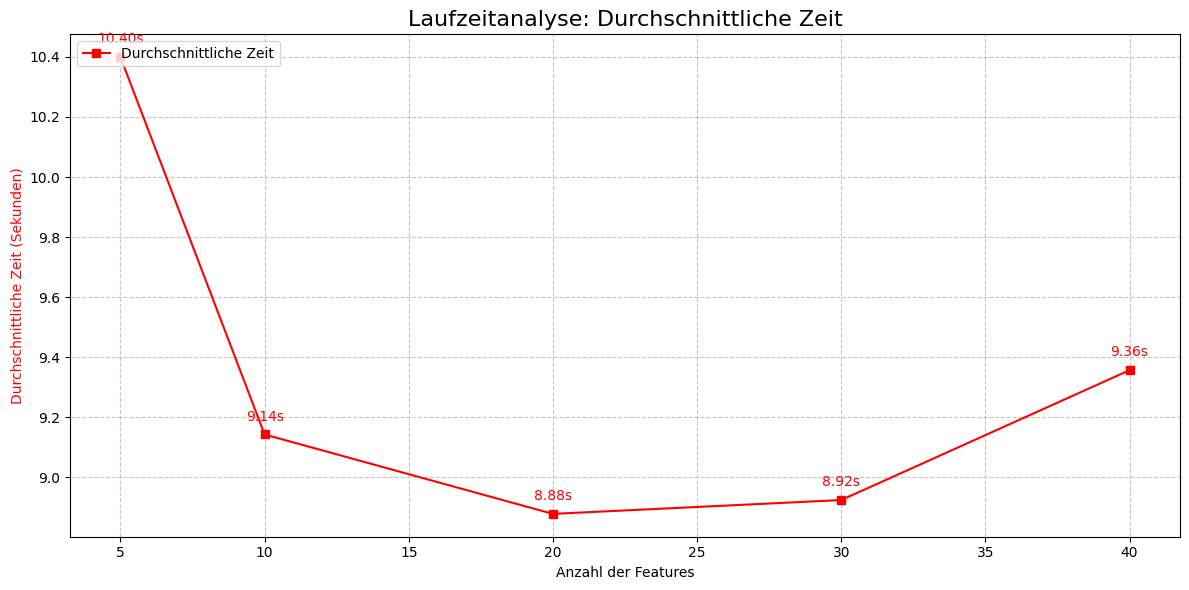

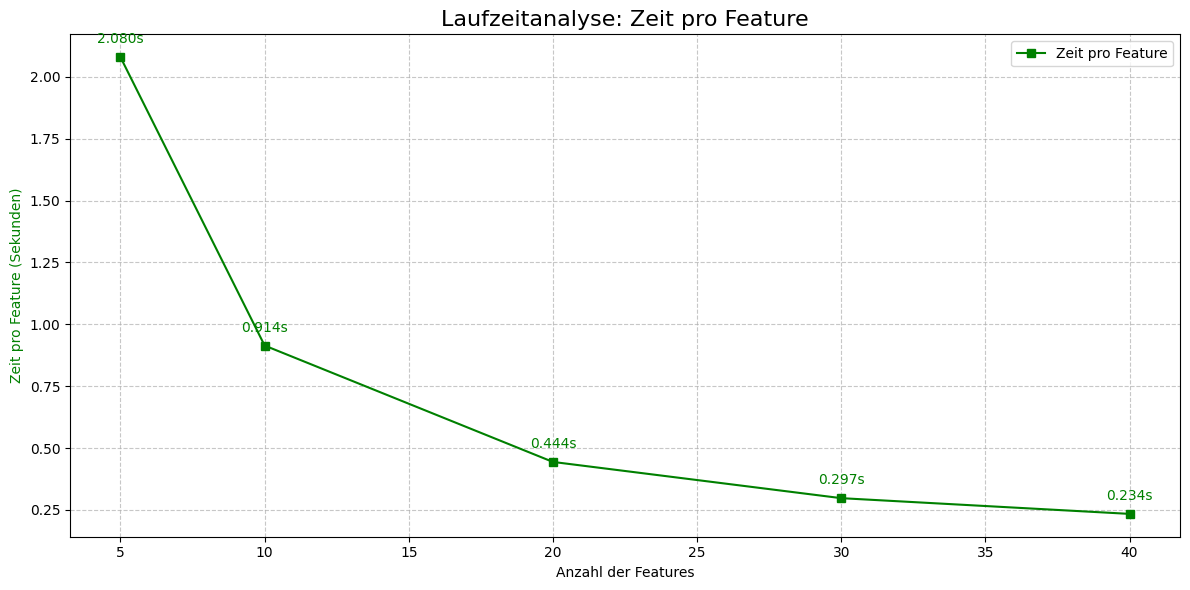

In [126]:
import matplotlib.pyplot as plt

fig2, ax2 = plt.subplots(figsize=(12, 6))
line2 = ax2.plot(n_features_list, avg_elapsed_times, 'r-', marker='s', label='Durchschnittliche Zeit')

ax2.set_xlabel('Anzahl der Features')
ax2.set_ylabel('Durchschnittliche Zeit (Sekunden)', color='r')

plt.title('Laufzeitanalyse: Durchschnittliche Zeit', fontsize=16)

ax2.legend(loc='upper left')

ax2.grid(True, linestyle='--', alpha=0.7)

for x, y in zip(n_features_list, avg_elapsed_times):
    ax2.annotate(f'{y:.2f}s', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='r')

plt.tight_layout()

plt.show()

# Plot für durchschnittliche Zeit pro Feature
fig3, ax3 = plt.subplots(figsize=(12, 6))
line3 = ax3.plot(n_features_list, times_per_feature, 'g-', marker='s', label='Zeit pro Feature')
ax3.set_xlabel('Anzahl der Features')
ax3.set_ylabel('Zeit pro Feature (Sekunden)', color='g')
plt.title('Laufzeitanalyse: Zeit pro Feature', fontsize=16)
ax3.legend(loc='upper right')
ax3.grid(True, linestyle='--', alpha=0.7)

# Annotationen für die Datenpunkte
for x, y in zip(n_features_list, times_per_feature):
    ax3.annotate(f'{y:.3f}s', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='g')

plt.tight_layout()
plt.show()